# Simulating Dynamical Diffraction with `py4DSTEM.process.diffraction`

### Acknowledgements

This tutorial was created by the py4DSTEM instructor team:
- Steve Zeltmann (steven.zeltmann@berkeley.edu)
- Colin Ophus (clophus@lbl.gov)
- Ben Savitzky (bhsavitzky@lbl.gov)
- Stephanie Ribet (sribet@lbl.gov)
- Alex Rakowski (arakowski@lbl.gov)

### Notebook contents

`py4DSTEM.process.diffraction` provides a (relatively) simple interface to a powerful method for simulating electron diffraction-the Bloch wave method. In this notebook, we will perform several types of dynamical diffraction simulations:
* Plane wave diffraction
* Converged beam electron diffraction (PACBED)
* Position averaged CBED (PACBED)

In [1]:
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm

### Setup note:
The easiest way to define a crystal structure in `py4DSTEM.diffraction` is to import it from the Materials Project database using the MP ID for the material. Unfortunately, this requires that you have `pymatgen` installed, obtain a MP API key at [this link](https://next-gen.materialsproject.org/api), and either install it in your `pymatgen` config or pass it as an argument to the initializer. To make this notebook easier to install and follow along, we instead initialize the `Crystal`s manually, so that `pymatgen` is not required. If you install and run this code yourself, we strongly recommend you set up Materials Project integration, as it will make things much easier and foolproof. For the two `Crystal`s we will create, the code for downloading the structural data from the Materials Project is left commented out, so that you can use it if you set up your environment properly. 

# Plane Wave Diffraction
The fundamental computation in a Bloch wave simulation is plane wave diffraction, and all of the other simulations we will discuss are built up from individual plane wave calculations. 

In this example, we will observe how the intensities of diffraction spots change as the crystal tilts slightly from its perfect zone-axis orientiation. The Bloch wave method will provide highly accurate intensities for this case.

To apply the Bloch wave method, we create the `Crystal` object just like in the previous notebook, and we calculate not only the ordinary structure factors but also the "dynamical" structure factors. These include the effects of the temperature of the crystal, inelastic scattering, and relativitistic effects, but fundamentally come from the same equation as the structure factors discussed previously. Only the $f_e^j$ and a new normalization factor in front of the summation are changed to include these effects.

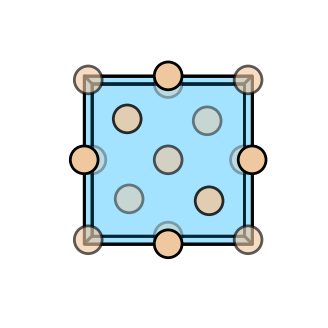

In [2]:
# Si = py4DSTEM.process.diffraction.Crystal.from_pymatgen_structure("mp-149")
# https://materialsproject.org/materials/mp-149/ – Silicon, diamond cubic

Si = py4DSTEM.process.diffraction.Crystal(
    positions=[
        [0.25, 0.75, 0.25],
        [0.0,  0.0,  0.5],
        [0.25, 0.25, 0.75],
        [0.0,  0.5,  0.0],
        [0.75, 0.75, 0.75],
        [0.5,  0.0,  0.0],
        [0.75, 0.25, 0.25],
        [0.5,  0.5,  0.5],
    ],
    numbers=14,
    cell=5.468728,
)

Si.plot_structure(figsize=(4,4))

In [3]:
# Calculate structure factors. In order to observe kinematically forbidden reflections,
# we need to include reciprocal lattice points where V_g = 0 in the list of beams for the Bloch method,
# so we set tol_structure_factor to zero.
Si.calculate_structure_factors(k_max=4.0, tol_structure_factor=-1.0)

# Convert the V_g to relativistic-corrected U_g and store in a datastructure optimized
# for access by the Bloch code
Si.calculate_dynamical_structure_factors(
    300e3, "WK-CP", k_max=4.0, thermal_sigma=0.08, tol_structure_factor=-1.0
)

In [4]:
ZA = np.array([0, 1, 1])  # Use the (111) zone axis

# Generate a kinemaical diffraction pattern, which will set which beams are included in
# the dynamical matrix. To include forbidden reflections, set the intensity tolerance to 0
# and use k_max to limit the number of beams.
beams = Si.generate_diffraction_pattern(
    zone_axis_lattice=ZA, 
    sigma_excitation_error=0.02,
    tol_intensity=0.0, 
    k_max=2,
)

# Check how many beams we are going to include. Around 100-200 is the sweet spot
# where accuracy will be high but computation time will be low.
beams.data.shape

(263,)

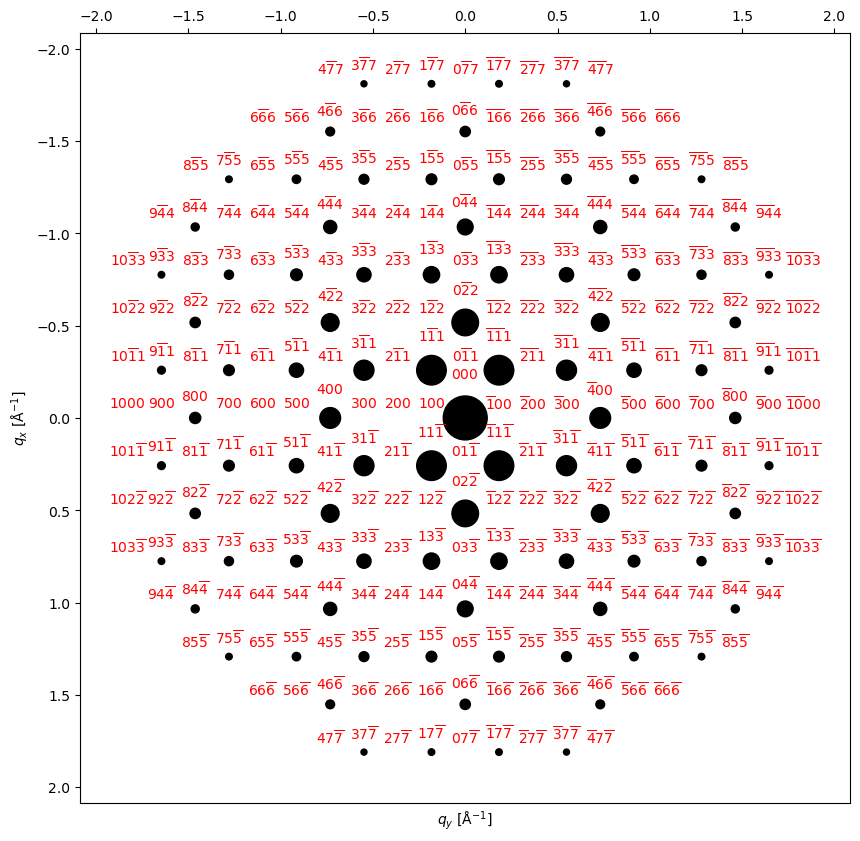

In [5]:
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    beams,
    scale_markers=4e3,
    add_labels=True,
    figsize=(10,10)
)

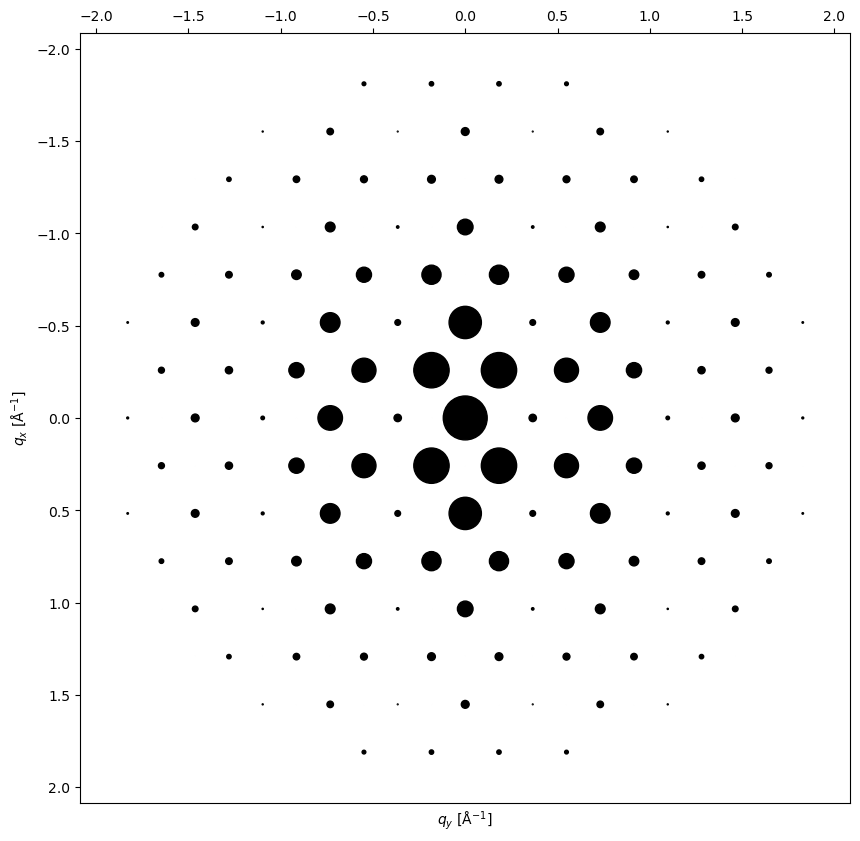

In [6]:
# Generate a dynamical diffraction pattern, at the specified thickness.# 
# The dynamical pattern will contain the same diffraction spots as `beams`, but
# the intensities now accurately include multiple scattering and absorption!

# note for example the 200 and -200 beams now have some intensity due to multiple scattering (for the [011] zone axis).

thickness = 50.  # Ångström - feel free to tweak this


pattern = Si.generate_dynamical_diffraction_pattern(
    beams=beams, 
    thickness=thickness, 
    zone_axis_lattice=ZA,
)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    pattern,
    scale_markers=4e3,
    add_labels=False,
    figsize=(10,10)
)

We'll simulate tilting along two axes by a couple steps each to produce a grid of patterns of various tilts. If you pick a different zone axis, you may need to choose a different pair of directions to tilt the crystal along. These directions should be perpendicular to the zone axis and to each other, so for the (1 1 1) ZA we'll choose (0 1 -1) and (2 -1 -1). (The easiest way to pick these axis is to simulate a diffraction pattern, and pick two diffraction spots that are 90° apart from one another). 

49it [00:40,  1.21it/s]


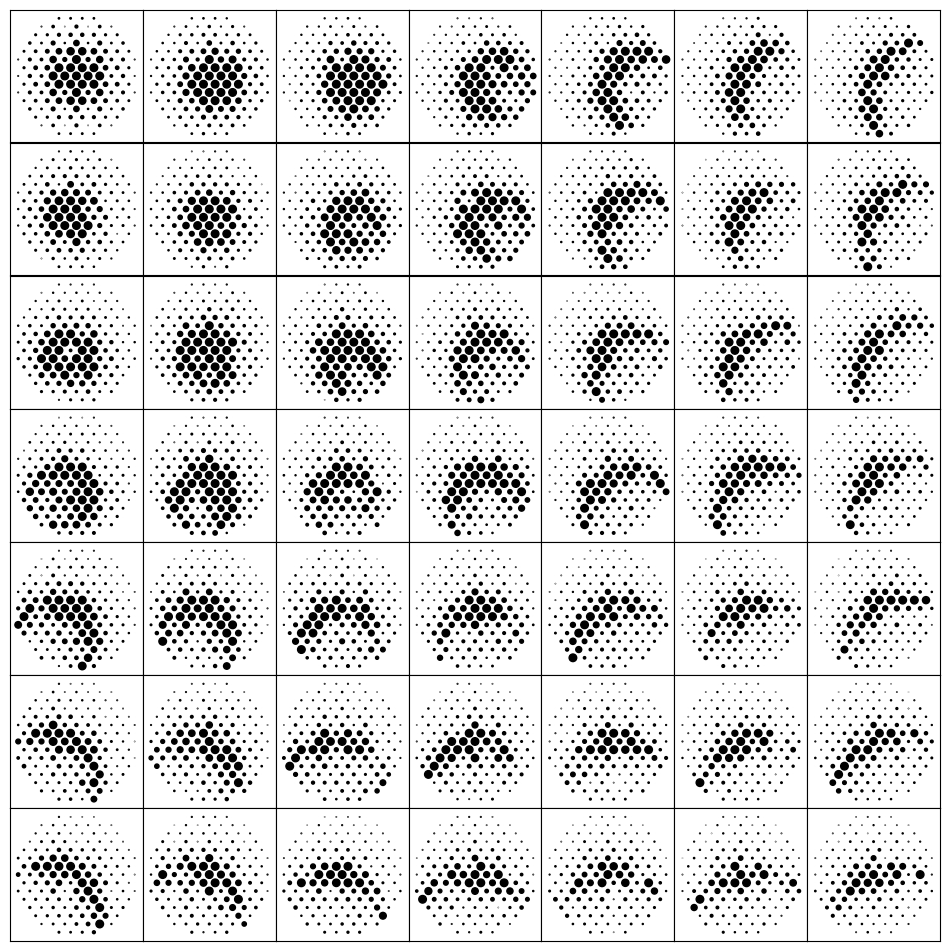

In [7]:
# Two rotation axes (perpendicular to the zone axis and to each other)
# axes for [111] ZA
rot_axis_a = [-1, -1, 2]
rot_axis_b = [-1, 1, 0]

# axes for [001] ZA
# rot_axis_a = [0, 1, 0]
# rot_axis_b = [-1, 0, 0]

# Amount to rotate along each axis
rot_a = 40.0  # milliradians (1° ≈ 17 mrad)
rot_b = 40.0  # milliradians

# Number of tilt steps
N_tilt = 7

# thickness
thickness_compare = 400

# Generate the grid of tilt values
tilt_a, tilt_b = np.meshgrid(
    np.linspace(0, rot_a, N_tilt), np.linspace(0, rot_b, N_tilt)
)

fig, ax = plt.subplots(N_tilt, N_tilt, figsize=(12, 12.1))

# Normalize the rotation axes:
rot_axis_a = np.array(rot_axis_a) / np.linalg.norm(rot_axis_a)
rot_axis_b = np.array(rot_axis_b) / np.linalg.norm(rot_axis_b)

# Loop over all the tilt values and the subplots together:
for ta, tb, a in tqdm(zip(tilt_a.flat, tilt_b.flat, ax.flat)):

    # Generate the rotations
    Ra = R.from_rotvec(ta / 1000.0 * rot_axis_a)
    Rb = R.from_rotvec(tb / 1000.0 * rot_axis_b)

    # Rotate the original zone axis
    tiltedZA = (Ra * Rb).apply(ZA)

    # Generate a dynamical diffraction pattern for this tilt
    pattern = Si.generate_dynamical_diffraction_pattern(
        beams=beams, thickness=thickness_compare, zone_axis_lattice=tiltedZA
    )

    # Plot the pattern in the correct axes in the figure
    py4DSTEM.process.diffraction.plot_diffraction_pattern(
        pattern,
        scale_markers=500,
        input_fig_handle=(fig, (a,)),
        # plot_range_kx_ky=(1.6,1.6),
        add_labels=False,
        max_marker_size = 30,
    )
    # a.axis('off')
    a.get_xaxis().set_ticks([])
    a.get_yaxis().set_ticks([])
    a.set_xlabel(None)
    a.set_ylabel(None)
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

This calculation shows how tilting the crystal away from the zone axis orientation causes the Laue circle (the ring of strongly excited reflections) to shift around the pattern. Understanding how the Laue circle corresponds to tilting of the crystal is essential for succesfully bringing a crystal onto a zone axis orientation! Notice strong dynamical effects in some of the patterns (particularly near a 2-beam condition)

# CBED Part I: Thickness Series

This is where the Bloch wave method shines! 

Dynamical diffraction causes strong oscillation of intensity between diffracted beams as the wave propagates through the crystal. By sampling a range of tilts of the crystal, we can observe these oscillations. This is typically done by capturing a CBED pattern: the range of angles in the electron probe cause the incident wave to become a "disk" in reciprocal space; that is, a CBED probe is a superposition of plane waves up to some maximum cutoff angle called the convergence angle. Each plane wave in the CBED probe diffracts "independently," so the CBED pattern represents a range of plane wave diffraction patterns from different tilts all at once. Because the excitation of the Bragg beams oscillates as a function of tilt with a period that is related to the crystal thickness, measuring the fringes that appear in a CBED pattern is a classic method to estimate the crystal thickness.

To perform this experiment, you would first tilt the crystal to a two-beam orientation. This ensures that the only two strongly excited beams are the center beam and the reflection we are using for calculations. (This is necessary in order to derive a simple relationship between the fringe spacing and the crystal thickness.) We'll have to figure out a tilt that gives us a two-beam condition, which we'll check with a quick plane wave diffraction calculation. 

Note that it is possible to force the Bloch wave CBED calculation to only include the direct beam and the strong beam, to make the fringes more dramatic while also decreasing the computation time. For simplicity (and accuracy) we will include all of the beams in the computation here. 

In [8]:
target_spot = np.array([-3,1,-1])  # The reflection we're trying to excite in a two-beam condition

# A vector orthogonal to the zone axis and the target spot direction
orth_spot = np.cross(ZA, target_spot)

orth_tilt = 60  # amount to tilt in perpendicular direction, in mrad

# get the scattering vector length of the target spot from the list of beams
target_idx = np.argwhere(
    np.logical_and.reduce(
            [beams.data["h"] == target_spot[0], 
             beams.data["k"] == target_spot[1],
             beams.data["l"] == target_spot[2]]
    )
)[0][0]

target_g_angle = (
    np.hypot(beams.data[target_idx]["qx"], beams.data[target_idx]["qy"]) * Si.wavelength
)  # angle between the direct beam and the target spot

Ra = R.from_rotvec(orth_spot / np.linalg.norm(orth_spot) * target_g_angle / 2.0)
Rb = R.from_rotvec(target_spot / np.linalg.norm(target_spot) * orth_tilt / 1000.0)

two_beam_ZA = (Ra * Rb).apply(ZA)

In [9]:
# After tilting to the two-beam condition, we are still near the original 111 orientation
print(two_beam_ZA)

[0.02853667 1.05496323 0.94140227]


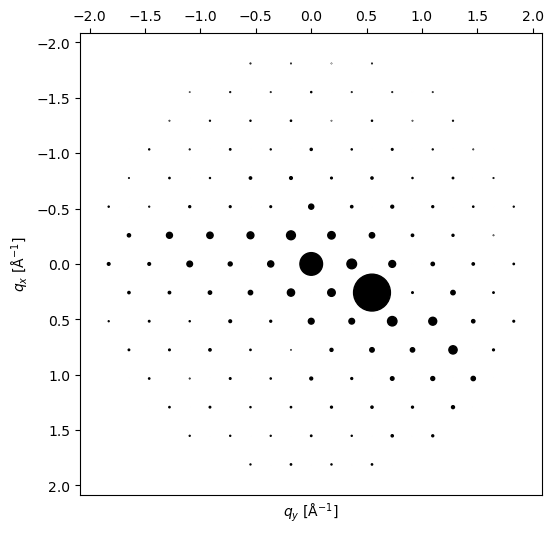

In [10]:
tilted_pattern = Si.generate_dynamical_diffraction_pattern(
    beams=beams, thickness=800.0, zone_axis_lattice=two_beam_ZA
)

py4DSTEM.process.diffraction.plot_diffraction_pattern(
    tilted_pattern, 
    add_labels = False,
    scale_markers = 1e3,
)

In [11]:
# To generate CBED patterns at multiple thickness, pass an array of thickness values 
# and the return value will be a list of CBED patterns
thickness = np.array([100, 500, 1000, 1500])  # Ångström - feel free to tweak this
CBED = Si.generate_CBED(
    beams=beams,
    thickness=thickness,
    alpha_mrad=2.8,
    pixel_size_inv_A=0.02,
    zone_axis_lattice=two_beam_ZA,
)

100%|█████████████████████████████████████████████████████████████████████████████████| 145/145 [04:13<00:00,  1.75s/it]


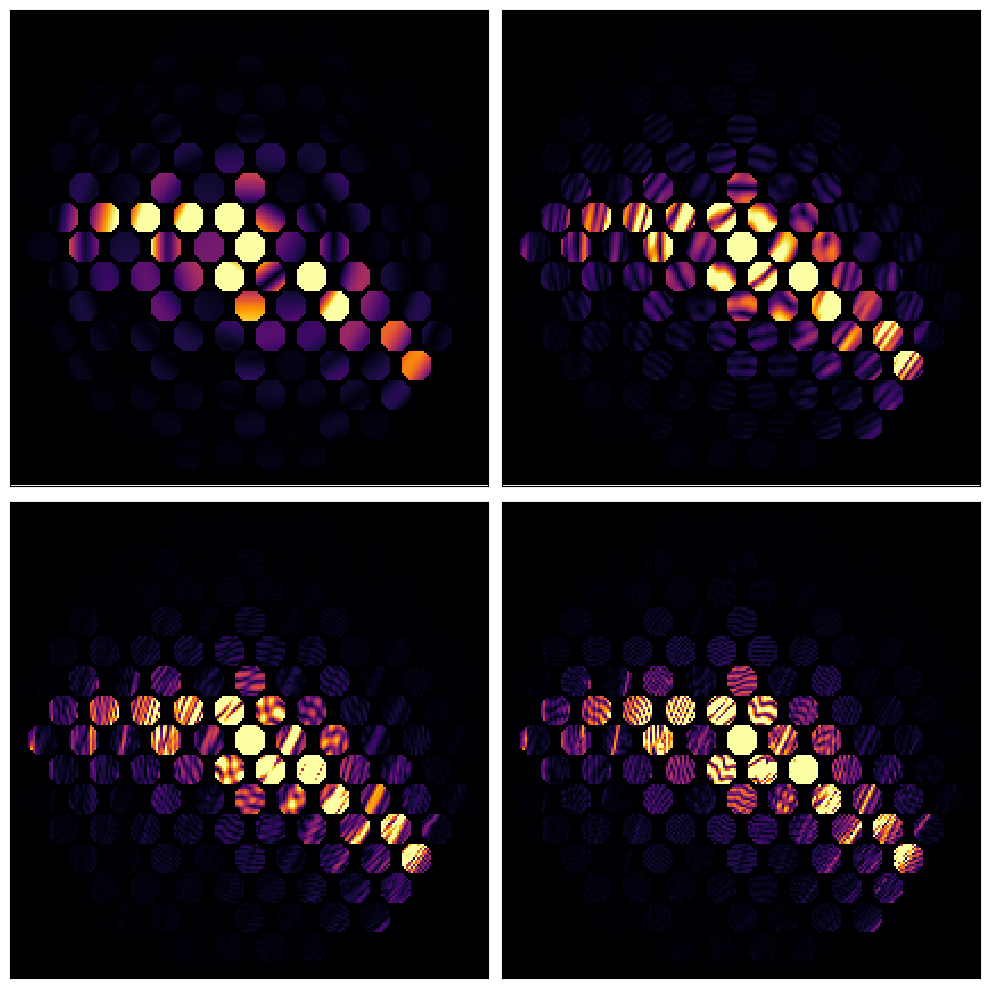

In [12]:
py4DSTEM.visualize.show_image_grid(
    lambda i: CBED[i],
    2,
    2,
    axsize=(5,5),
    scaling='power',
    power=0.5,
    cmap='inferno',
    ticks=False,
)

# CBED Part II: HOLZ lines

Higher-order Laue zone spots arise from reciprocal lattice points that are not in the first "layer" of spots–this means that they contain information that is "3-dimensional," in that they correspond to spacings that contain a component along the beam direction. These spots rarely appear clearly in zone-axis plane-wave patterns because these spots are far more sensitive to crystal tilt than ZOLZ spots, and scattering to such high angles is often very weak. In convergent beam diffraction we illuminate the sample with many tilts simultaneously, and this range of tilts is enough that at some tilts some of the HOLZ reflections will be strongly excited. The strong tilt sensitivity causes these reflections to appear as thin bright lines at high scattering angle, and corresponding dark lines are present in the direct beam. 

In [13]:
# To make the HOLZ lines more prominent, we will go to a lower accelerating voltage
# We also set k_max higher to include more couplings between high angle beams
Si.calculate_dynamical_structure_factors(
    accelerating_voltage=60e3, thermal_sigma=0.08, k_max=5.0, tol_structure_factor=0.0
)

In [14]:
HOLZ_ZA = np.array([0, 0, 1])

# Generate a kinemaical diffraction pattern, which will set which beams are included in
# the dynamical matrix.
HOLZ_beams = Si.generate_diffraction_pattern(
    zone_axis_lattice=HOLZ_ZA, 
    sigma_excitation_error=0.02,
    tol_intensity=1e-9, 
    k_max=3.0,
)

# Check how many beams we are going to include.
HOLZ_beams.data.shape

(57,)

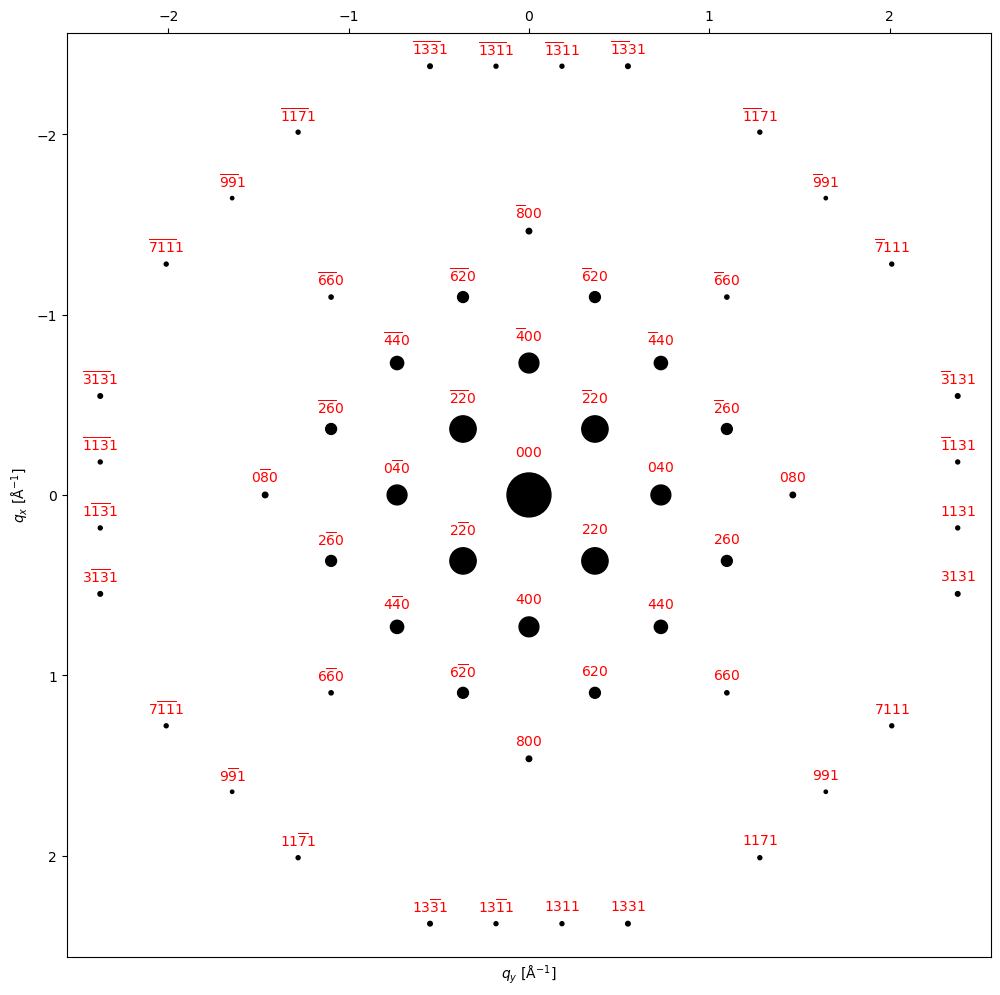

In [15]:
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    HOLZ_beams,
    scale_markers=4e3,
    add_labels=True,
    figsize=(12,12),
)

In [16]:
thickness = 2000 # Ångström - feel free to tweak this, but keep it fairly thick to see sharp HOLZ lines

# Setting the pixel size smaller will make the HOLZ lines clearer.
# The settings we're suggesting here (8 mrad, 0.01 1/Å/pix) make sure the simulation runs fast enough for 
# the demo, (on my iMac this will take <1 minute) but to see things more clearly you may want to tweak them later. 

HOLZ_CBED = Si.generate_CBED(
    beams=HOLZ_beams,
    thickness=thickness,
    alpha_mrad=8,
    zone_axis_lattice=HOLZ_ZA,
    pixel_size_inv_A=0.01,
)

100%|█████████████████████████████████████████████████████████████████████████████████| 793/793 [00:27<00:00, 29.30it/s]


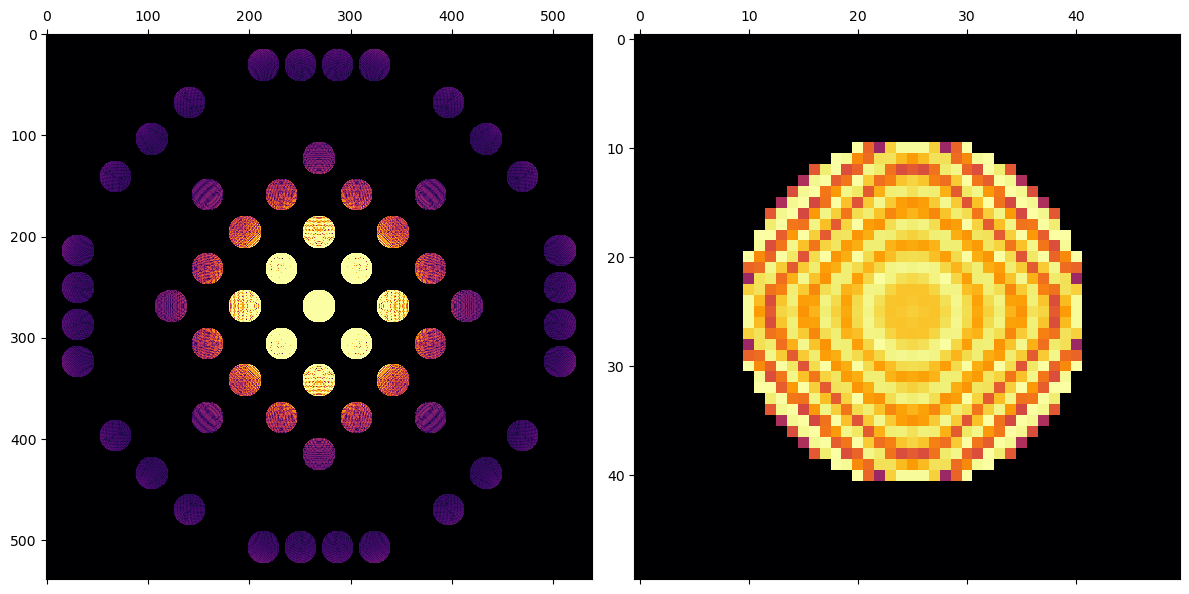

In [17]:
# Let's plot the whole pattern next to the cropped direct beam

w = 50//2  # width of crop window for center beam

Nx, Ny = HOLZ_CBED.shape
Cx, Cy = Nx // 2, Ny // 2

py4DSTEM.visualize.show_image_grid(
    lambda i: [HOLZ_CBED, HOLZ_CBED[Cx - w : Cx + w, Cy - w : Cy + w]][i],
    H=1,
    W=2,
    scaling="power",
    power=0.25,
    cmap="inferno",
)

# PACBED

Position averaged CBED is a modern technique for determining crystal thickness and orientation. In short, to acquire a PACBED pattern a sub-atomic size focused probe is scanned across the sample. Ordinarily, the diffraction pattern of a sub-unit-cell probe is **strongly** dependent on the position of the probe within the unit cell. In PACBED, these patterns are summed (incoherently) for all positions within the unit cell, either by scanning the probe across the unit cell during one detector exposure or by summing patterns after-the-fact from a 4D-STEM dataset. This is mathematically equivalent to summing all of the individual plane wave diffraction conditions incoherently; thus, to simulate PACBED using the Bloch method we simply use our ordinary incoherent CBED function but with a larger convergence angle! 

In [18]:
# For PACBED simulations, we'll use strontium titanate

# STO = py4DSTEM.process.diffraction.Crystal.from_pymatgen_structure("mp-5229") # SrTiO3 cubic

# Manually specify:

lat = 3.9451
positions = np.array([[0. , 0. , 0. ],
                      [0.5, 0.5, 0.5],
                      [0.5, 0. , 0.5],
                      [0.5, 0.5, 0. ],
                      [0. , 0.5, 0.5]])
Z = [38, 22,  8,  8,  8]

STO = py4DSTEM.process.diffraction.Crystal(positions, Z, lat)

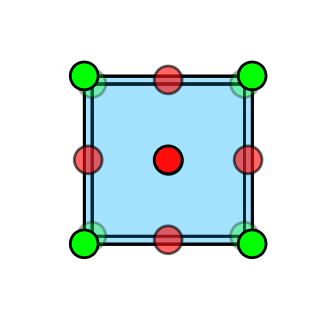

In [19]:
STO.plot_structure(figsize=(4,4))

In [20]:
# Calculate structure factors
STO.calculate_structure_factors(k_max=2.0, tol_structure_factor=0.0)

# Convert the V_g to relativistic-corrected U_g
STO.calculate_dynamical_structure_factors(300e3, "WK-CP", k_max=2.0, thermal_sigma=0.08, tol_structure_factor=0.0)

In [21]:
# Generate a kinemaical diffraction pattern, which will set which beams are included in
# the dynamical matrix.
ZA_STO = [0,0,1]
beams_STO = STO.generate_diffraction_pattern(zone_axis_lattice=ZA_STO, tol_intensity=0., k_max=2.5, tol_excitation_error_mult=1)

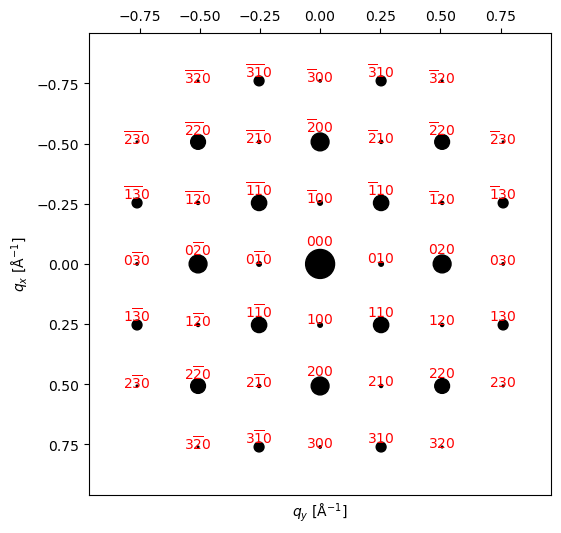

In [22]:
py4DSTEM.process.diffraction.plot_diffraction_pattern(
    beams_STO,
    scale_markers=1000,
    shift_labels=0.01,
    shift_marker=0.004,
    min_marker_size=0,
)

In [23]:
# Generate a converged beam electron diffraction pattern. 

# Note that the parameters for this calculation have been chosen to match Fig 2 in https://doi.org/10.1016/j.ultramic.2009.10.001
thickness = np.array([10.,11.,12.,13.,14.,15.])*10.

DP = STO.generate_CBED(
    beams_STO,
    thickness=thickness,
    alpha_mrad=10,
    pixel_size_inv_A=0.04,
    DP_size_inv_A=1.0, # Use this to crop the patterns, or leave as None to auto-size to fit the entire pattern
    zone_axis_lattice=ZA_STO,
)

100%|█████████████████████████████████████████████████████████████████████████████████| 517/517 [00:31<00:00, 16.19it/s]


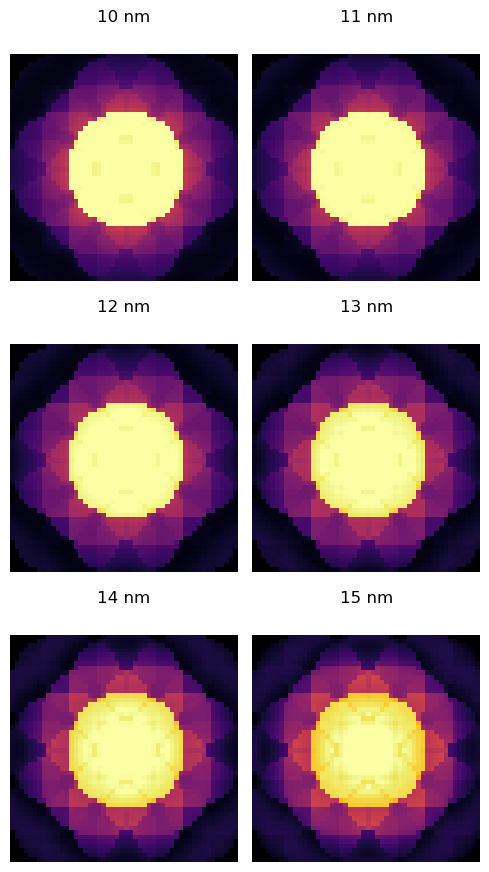

In [24]:
fig,ax = plt.subplots(3,2,figsize=(5,9),tight_layout=True)
for a,dp,t in zip(ax.ravel(),DP,thickness):
    a.matshow(dp**0.5, cmap='inferno',vmin=0,vmax=0.8)
    a.axis('off')
    a.set_title(f"{t/10:0.0f} nm")
fig.patch.set_facecolor('w') 
plt.show()